In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py
import random

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform

import gym
import mazelab
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

from stable_baselines3 import A2C
sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from captum.attr import (
    Saliency,
    IntegratedGradients,
    FeatureAblation,
    FeaturePermutation,
    Occlusion,
    ShapleyValueSampling    
)

In [2]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print(f"Using {device} device")

Using cpu device


In [3]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        w, h = env.observation_space.shape
        features = 2 * w * h
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(features, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 1, bias=False),
        ).to(device)
        self.device = device

    def forward(self, obs):
        return self.net(th.tensor(obs).to(self.device))
    
    def tforward(self, ss):
        return self.net(ss)

In [4]:
env_id = 'EmptyMaze-10x10-CoinFlipGoal-v3'
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-CoinFlipGoal-v3


In [5]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [6]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/test.gif', images, fps=29)
Image(filename=f"tmp/test.gif", width=110, height=110)

In [7]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}_ss-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [8]:
plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
    "font.serif": ["Times"],
})

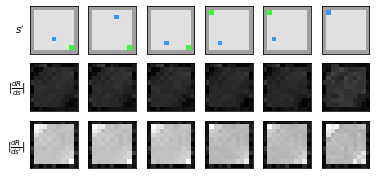

In [36]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

plt.figure(figsize=(5.5, 2.5))

sal = Saliency(rm.tforward)
w = 6
i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=True)
    next_obs, reward, done, info = env.step(action)
    if i == w:
        obs = env.reset()
        goal_pos = env.maze.objects.goal.positions[0]
        if goal_pos == [1, 1]:
            agent_pos = [2, 1]
        else:
            agent_pos = [8, 9]
        env.maze.objects.agent.positions[0] = agent_pos
        obs = env.maze.to_value()
        env.maze.objects.agent.positions[0] = goal_pos
        next_obs = env.maze.to_value()
    
    top_left = (env.maze.objects.goal.positions[0] == [1, 1])
    if (i in [1, 2, 3] and top_left) or (i in [4, 5, 6] and not top_left):
        continue
    
    ax = plt.subplot(3, w, i)
    screenshot = env.maze.to_rgb()
    ax.imshow(screenshot)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     plt.axis('off')
    if i == 1:
        ax.set_ylabel(r"$s'$", rotation=0, fontsize=10, fontfamily="Times New Roman")
        ax.yaxis.set_label_coords(-0.22, 0.4)

    input = np.array((obs, next_obs)).astype(np.float32)
    input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])

    ax = plt.subplot(3, w, w+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(attributions[0, ...], cmap='gray', vmin=attributions.min(), vmax=attributions.max())
    if i == 1:
        ax.set_ylabel(r"$\left\vert \frac{dR}{ds} \right\vert$", rotation=0, fontsize=10, fontfamily="Times New Roman")
        ax.yaxis.set_label_coords(-0.28, 0.3)


    ax = plt.subplot(3, w, 2*w + i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(attributions[1, ...], cmap='gray', vmin=attributions.min(), vmax=attributions.max())
    if i == 1:
        ax.set_ylabel(r"$\left\vert \frac{dR}{ds'} \right\vert$", rotation=0, fontsize=10, fontfamily="Times New Roman")
        ax.yaxis.set_label_coords(-0.28, 0.26)

    i += 1
    
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.05, top=0.95)

plt.savefig(f"figures/CoinFlipsaliencymapssixstates.pdf", dpi=350)


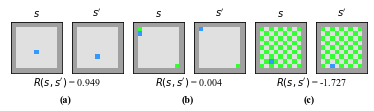

In [14]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

plt.figure(figsize=(5.5, 1.7))

# No Goal Object:
env.reset()
obs = env.maze.to_value()
goal_pos = tuple(map(int, np.where(obs==3)))
empty_pos = (np.where(obs == 0)[0][0], np.where(obs == 0)[1][0])
s = env.maze.to_rgb()
obs[goal_pos] = obs[empty_pos]
s[goal_pos] = s[empty_pos]

action, _states = model.predict(obs, deterministic=True)
next_obs, reward, done, info = env.step(action)
goal_pos = tuple(map(int, np.where(next_obs==3)))
empty_pos = (np.where(next_obs == 0)[0][0], np.where(next_obs == 0)[1][0])
sp = env.maze.to_rgb()
next_obs[goal_pos] = next_obs[empty_pos]
sp[goal_pos] = sp[empty_pos]

ax = plt.subplot(1, 6, 1)
ax.imshow(s)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s$", fontsize=10, fontfamily="Times New Roman")

ax = plt.subplot(1, 6, 2)
ax.imshow(sp)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s'$", fontsize=10, fontfamily="Times New Roman")

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
ax.set_xlabel("$R(s, s')$ = {:.3f}".format(rm.tforward(input).item()), fontsize=10, fontfamily="Times New Roman")
ax.xaxis.set_label_coords(-0.1, -0.05)
ax.text(-3.2, 16.7, '(a)', fontsize=10, weight="bold", fontfamily="Times New Roman")


# Two Goal Objects:
env.reset()
env.maze.objects.goal.positions = [[1, 1], [9, 9]]
env.maze.objects.agent.positions = [[2, 1]]
obs = env.maze.to_value()
s = env.maze.to_rgb()

action, _states = model.predict(obs, deterministic=True)
next_obs, reward, done, info = env.step(action)
sp = env.maze.to_rgb()


ax = plt.subplot(1, 6, 3)
ax.imshow(s)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s$", fontsize=10, fontfamily="Times New Roman")

ax = plt.subplot(1, 6, 4)
ax.imshow(sp)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s'$", fontsize=10, fontfamily="Times New Roman")

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
ax.set_xlabel("$R(s, s')$ = {:.3f}".format(rm.tforward(input).item()), fontsize=10, fontfamily="Times New Roman")
ax.xaxis.set_label_coords(-0.1, -0.05)
ax.text(-3.2, 16.7, '(b)', fontsize=10, weight="bold", fontfamily="Times New Roman")
# ax.plot([12, 12], [-3, 13], color='black', lw=1)


# Spamming goal objectives:
env.reset()
agent_pos = env.maze.objects.agent.positions
for i in range(0, 9*9, 1):
    if i % 2 == 0:
        x, y = i // 9, i % 9
        x, y = x+1, y+1
        if agent_pos != [x, y]:
            env.maze.objects.goal.positions.append([x, y])
obs = env.maze.to_value()
s = env.maze.to_rgb()

action, _states = model.predict(obs, deterministic=True)
next_obs, reward, done, info = env.step(action)
sp = env.maze.to_rgb()


ax = plt.subplot(1, 6, 5)
ax.imshow(s)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s$", fontsize=10, fontfamily="Times New Roman")

ax = plt.subplot(1, 6, 6)
ax.imshow(sp)
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(r"$s'$", fontsize=10, fontfamily="Times New Roman")

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
ax.set_xlabel("$R(s, s')$ = {:.3f}".format(rm.tforward(input).item()), fontsize=10, fontfamily="Times New Roman")
ax.xaxis.set_label_coords(-0.1, -0.05)

ax.text(-3.2, 16.7, '(c)', fontsize=10, weight="bold", fontfamily="Times New Roman")

plt.subplots_adjust(left=0.05, right=0.95)

plt.savefig(f"figures/CoinFlipcounterfactuals.pdf", dpi=350)

In [11]:
def get_logits(input):
    latent, _, _ = model.policy._get_latent(input)
    return model.policy.action_net(latent)

In [12]:
action_to_direction = {
    0: "⬆",
    1: "⬇",
    2: "⬅",
    3: "➡"
}

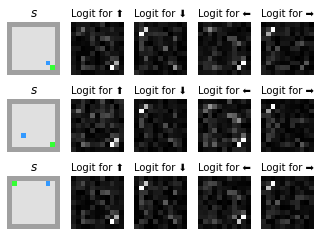

In [18]:
plt.figure(figsize=(5.5, 4.0))

N = 3 # rows (number of resets)

for n in range(N):

    plt.subplot(N, 5, 5*n + 1)
    plt.imshow(env.get_image())
    plt.title("$s$")
    plt.axis('off')

    sal = Saliency(get_logits)

    obs = env.reset()
    for k in range(0, 4):
        plt.subplot(N, 5, 5*n + k+2)
        input = th.tensor(np.expand_dims(obs.flatten(), axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
#         print(input.shape)
        attributions = sal.attribute(input, target=k-1)
        attributions = np.abs(attributions.detach())
        attributions = attributions.reshape(11, 11)

    #     policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    #     model.policy.action_net(policy_latent)[0][k].backward()
    #     gradients = obs_t.grad.cpu().detach().numpy().reshape((15, 15))

    #     plt.subplot(1, 4, k+1)
        plt.title(f"Logit for {action_to_direction[k]}", fontsize=10)
        plt.imshow(attributions, cmap='gray')
        plt.axis('off')

plt.savefig(f"figures/CoinFlipPolicySaliency.pdf", dpi=300)
